# Molecular Dynamics: Lab 1

In part based on [Fortran code from Furio Ercolessi](http://www.fisica.uniud.it/~ercolessi/md/f90/).

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

## Basics of Molecular Dynamics

In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12,6)

The basic idea of molecular dynamics is to follow the location of the particles in time using Newton's laws. Each particle has a location $\vec{X}_i$ which obeys

$$
\begin{equation}
  m_i \frac{d^2}{d t^2} \vec{X}_i = m_i \vec{A}_i = -\nabla V \left( \vec{X}_1, \dots, \vec{X}_N \right).
\end{equation}
$$

Most of the time we will work in computational coordinates, rescaled by a reference length $L$, so that the particles obey

$$
\begin{equation}
  \frac{d^2}{d t^2} \vec{x}_i = \vec{a}_i = -\nabla V \left( \vec{x}_1, \dots, \vec{x}_N \right).
\end{equation}
$$

This gives us a computational domain, once translated to the centre-of-mass, of $\vec{x} \in [-0.5, 0.5]^3$.

The simplest possibility is that the interaction potential $V$ is the sum of pairwise interactions, 

$$
\begin{equation}
  V \left( \vec{x}_1, \dots, \vec{x}_N \right) = \sum_i \sum_{j>i} \phi \left( L \left| \vec{x}_i - \vec{x}_j \right| \right).
\end{equation}
$$

The most commonly used pairwise interaction potential is the *Lennard-Jones* potential

$$
\begin{equation}
  \phi(r) = 4 \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right].
\end{equation}
$$

To stop this potential extending for infinite distance a cutoff is used; $\phi(r) \to \phi(r) - \phi(R_c)$, where $R_c$ is a constant (here $2.5$ when $\sigma = 1 = \varepsilon = M_i$).

As, in this case,

$$
\begin{equation}
  \frac{d}{dr} \phi(r) = 24 \left[ 2 \left( \frac{1}{r} \right)^{14} - \left( \frac{1}{r} \right)^{8} \right],
\end{equation}
$$

we have

$$
\begin{equation}
  \vec{a}_i = -\left. \nabla V \right|_{i} = \sum_{j>i}  (\vec{x}_i - \vec{x}_j) \, \frac{d}{dr} \phi(r) - \sum_{j<i}  (\vec{x}_j - \vec{x}_i) \, \frac{d}{dr} \phi(r).
\end{equation}
$$

Note that Newton's third law means that the force on particle $i$ from particle $j$ must be exactly opposite to the force on particle $j$ from particle $i$. So the algorithm can be implemented by setting $\vec{a}_i = 0$ and, for each particle $i$, and for all $j > i$, setting *both*

1. $\vec{a}_i = \vec{a}_i + (\vec{x}_i - \vec{x}_j) \, \frac{d}{dr} \phi(r)$,
2. $\vec{a}_j = \vec{a}_j - (\vec{x}_i - \vec{x}_j) \, \frac{d}{dr} \phi(r)$.

Implement an algorithm to calculate the acceleration given the positions.

In [29]:
@jit
def dLJ(pos, i, j, rc):
    diff = pos[i, :] - pos[j, :]
    # Contains three cases: closer as is, closer to the left, closer to the right
    cases = np.array([0, -0.5, 0.5])
    for n in range(pos.shape[1]):
        # Add to the directions of interest to see if particles are closer over
        # the periodic boundaries
        index = np.argmin(np.abs(diff[n] + cases))
        diff[n] += cases[index]
    r = np.linalg.norm(diff)
    if r < rc:
        return 24 * (2 * r**(-14) - r**(-8))
    else:
        return 0.0

In [30]:
@jit
def accel(pos, acc, i, j, rc):
    dLJ_local = dLJ(pos, i, j, rc)
    pos_diff = pos[i, :] - pos[j, :]
    acc_new = acc[:]
    acc_new[i, :] += pos_diff * dLJ_local
    acc_new[j, :] -= pos_diff * dLJ_local
    return acc_new

### Time evolution

The problem with time integrating is that most numerical algorithms do not conserve the total energy of the system, which can be be crucial. Certain algorithms, such as the [velocity Verlet](http://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet) algorithm, do conserve total energy.

#### Velocity Verlet

Given initial positions $\vec{x}$ and velocities $\vec{v}$ of each particle, the algorithm can be written as

1. $x^{n+1} = \vec{x}^n + \Delta t \, \vec{v}^n + \tfrac{1}{2} \Delta t^2 \, \vec{a}^n$
2. $\vec{v}^{*} = \vec{v}^n + \tfrac{1}{2} \Delta t \, \vec{a}^n$;
3. Derive $\vec{a}^{n+1}$ from the interaction potential using $\vec{x}^{n+1}$;
4. $\vec{v}^{n+1} = \vec{v}^{*} + \tfrac{1}{2} \Delta t \vec{a}^{n+1}$.

Implement this algorithm.

In [16]:
@jit
def vv(pos, vel, acc, dt, rc):
    N, dim = np.shape(pos)
    acc_new = acc[:]
    pos_new = pos + vel * dt + 0.5 * dt**2 * acc
    pos_new = part_reset(pos_new)
    vel_star = vel + 0.5 * dt * acc
    for i in np.arange(N):
        for j in np.arange(i+1, N):
            acc_new = accel(pos_new, acc_new, i, j, rc)
    vel_new = vel_star + 0.5 * dt * acc
    return pos_new, vel_new, acc_new

### Periodic boundaries

If we just evolved the particles, they could fly off to infinity. Instead it is typical to work inside a box with periodic boundaries, so that there is an "infinite lattice" of particles.

Implement a function that resets the position of particles that leave the given domain; the velocities and particles should remain unchanged.

In [10]:
def part_reset(pos):
    pos[pos > 0.5] -= 1.0
    pos[pos < -0.5] += 1.0
    return pos

### What to compute

The fundamental quantity is the location of the particles. However, the thing to analyze will be average properties of the particles; their mean temperature, pressure and energies.

Implement a function, given the particle locations $\vec{x}$ to compute the temperature, where

$$
\begin{align}
%  E_{\text{potential},\ i} &= \sum_{j /ne i} \phi \left( L \left| \vec{x}_i - \vec{x}_j \right| \right), \\
  E_{\text{kinetic},\ i} &= \tfrac{1}{2} L^2 \left| \vec{v}_i \right|^2, \\
  T & = \frac{2}{3 N} \sum_{i=1}^N E_{\text{kinetic},\ i}.
\end{align}
$$

In [11]:
def temperature(vel, boxSize):
    N = vel.shape[0]
    energy = np.sum(np.einsum('ij,ji->i', vel, vel.T))
    return boxSize**2 * energy / float(3 * N)


### Run in a box

Fix the domain to be $\vec{x} \in [0, 6.1984]^3$. Fix the timestep to be $0.032$ and take 100 timesteps, given the initial data prescribed in `input.dat` (see `data/MD/input.dat` on github). Remember to rescale the initial coordinates so that

1. The computational domain is $[-0.5, 0.5]^3$;
2. The average particle location is the origin.

That is, given the data $\vec{X}$ from `input.dat` do

1. $\vec{x} = \vec{X} / L$ where $L = 6.1984$;
2. $\vec{x} \to \vec{x} - \text{average}(\vec{x})$.

In [26]:
def sim(filename, boxSize, rc, dt, steps):
    pos_orig = np.loadtxt(filename, skiprows=1)
    cpos = pos_orig / float(boxSize) - 0.5
    cpos -= np.mean(cpos, axis=0)
    cpos = part_reset(cpos)
    all_pos = np.zeros((steps+1, cpos.shape[0], cpos.shape[1]))
    all_pos[0, :, :] = cpos
    cvel = np.zeros_like(cpos)
    cacc = np.zeros_like(cpos)
    time = np.arange(0.0, steps*dt, dt)
    time = np.append(time, steps*dt)
    T = np.zeros_like(time)
    T[0] = temperature(cvel, boxSize)
    for i in np.arange(1, steps+1):
        cpos, cvel, cacc = vv(cpos, cvel, cacc, dt, rc)
        all_pos[i, :, :] = cpos[:]
        T[i] = temperature(cvel, boxSize)
    return all_pos, time, T

In [27]:
filename = "./input.dat"
boxSize = 6.1984
dt = 0.032
steps = 100
rc = 2.5
pos, t, T = sim(filename, boxSize, rc, dt, steps)

Then plot some basic quantities, such as

1. The temperature as a function of time;
2. The trajectory of the first two particles as a function of time (using `plot3D`);
3. The trajectories of all the particles.

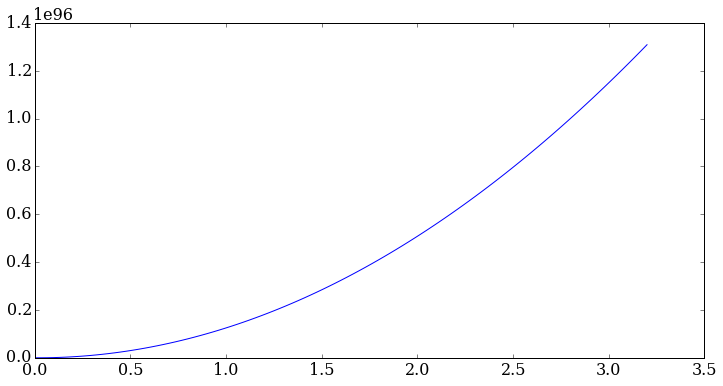

In [28]:
pyplot.plot(t, T)

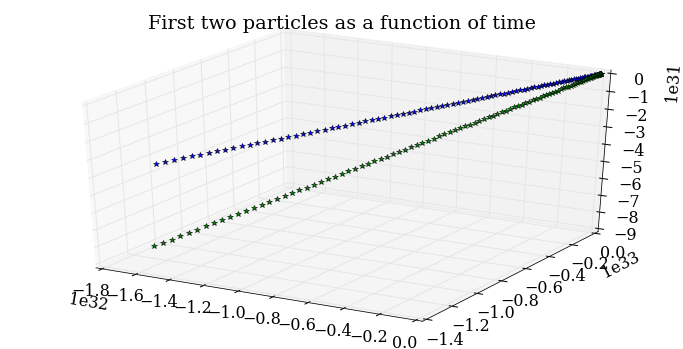

In [33]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
for particle in range(2):
    ax.plot3D(pos[:,0,particle], pos[:,1,particle], pos[:,2,particle], '*');
ax.set_title('First two particles as a function of time');